In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import bs4

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


In [15]:
from os import listdir
from os.path import isfile, join

In [16]:
onlyfiles = [f for f in listdir('data/forbes') if isfile(join('data/forbes', f))]
prices = pd.read_csv('data/forbes/A.csv')
prices['Date']= pd.to_datetime(prices['Date'],format="%d-%m-%Y")
prices = prices[prices['Date'] > '23-10-2012']
prices = prices[['Date','Close']]
#prices = prices.set_index('Date')
prices = prices.rename(columns={'Close':'A'})
prices

,Date,A
3254,2012-10-24,25.643778
3255,2012-10-25,25.829758
3256,2012-10-26,25.708155
3257,2012-10-31,25.743919
3258,2012-11-01,26.537910
...,...,...
5765,2022-10-18,132.300003
5766,2022-10-19,128.960007
5767,2022-10-20,125.940002
5768,2022-10-21,129.880005


In [17]:
#onlyfiles

In [18]:
for x in onlyfiles[1:]:
    path = 'data/forbes/'+x
    df = pd.read_csv(path)
    if df['Volume'].mean() < 100000:
        continue
    df['Date']= pd.to_datetime(df['Date'],format="%d-%m-%Y")
    df = df[df['Date'] > '23-10-2012']
    df = df[['Date','Close']]
    df = df.rename(columns={'Close':x[:-4]})
    prices = prices.merge(df,how='left',left_on='Date',right_on='Date')
prices = prices.dropna(axis=1) #Drop Stocks with insufficient price history
prices_no = prices.drop(columns=['Date','RXMD','INTK']) #Drop Stocks with halts

In [149]:
prices

,Date,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADI,...,WTFC,WU,WY,WYNN,XEL,XOM,XPO,YUM,ZBH,ZION
0,2012-10-24,25.643778,12.370,66.849998,22.029642,39.660000,31.455688,14.863333,66.320000,38.169998,...,37.450001,17.980000,27.559999,112.290001,27.650000,89.879997,7.328289,50.273186,60.466019,21.309999
1,2012-10-25,25.829758,11.970,67.900002,21.769285,39.759998,31.561243,14.900000,66.660004,38.689999,...,37.580002,17.809999,27.299999,120.430000,28.030001,90.430000,7.351572,50.460102,62.116505,21.440001
2,2012-10-26,25.708155,11.920,68.139999,21.571428,39.340000,31.417303,14.686667,67.110001,39.040001,...,37.070000,17.930000,27.370001,118.970001,27.990000,90.620003,7.759022,50.251617,61.699028,21.219999
3,2012-10-31,25.743919,12.180,70.940002,21.261429,39.439999,31.426901,14.683333,67.410004,39.119999,...,36.950001,12.730000,27.690001,121.059998,28.250000,91.169998,7.991851,50.402588,62.339806,21.480000
4,2012-11-01,26.537910,12.550,81.000000,21.305000,40.919998,31.402910,14.850000,68.830002,40.330002,...,37.150002,12.270000,27.850000,122.900002,28.129999,91.599998,8.032596,52.350826,63.640778,21.780001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2022-10-18,132.300003,13.700,174.729996,143.750000,143.990005,104.980003,48.639999,264.049988,141.100006,...,92.300003,14.310000,29.850000,56.590000,61.619999,100.800003,47.320000,111.480003,109.029999,51.980000
2512,2022-10-19,128.960007,13.990,171.250000,143.860001,142.990005,98.110001,48.720001,264.059998,141.330002,...,92.559998,14.250000,29.049999,54.480000,61.099998,103.790001,45.250000,110.449997,108.120003,49.220001
2513,2022-10-20,125.940002,13.460,170.279999,143.389999,142.770004,95.209999,47.520000,261.779999,142.080002,...,89.980003,13.440000,28.940001,56.130001,59.730000,103.930000,44.889999,109.660004,106.330002,47.130001
2514,2022-10-21,129.880005,13.710,171.339996,147.270004,147.729996,95.059998,48.230000,269.570007,146.589996,...,91.169998,13.630000,29.959999,58.799999,60.900002,105.860001,45.750000,111.029999,107.389999,47.820000


In [19]:
stocks_pct = prices_no.pct_change()
ret = stocks_pct.mean()*252
var = stocks_pct.var()*252
sharpe = ret/var
stats_df = pd.DataFrame(stocks_pct.columns,columns=['Ticker'])
stats_df['std'] = (var.values)**0.5
stats_df['ret'] = ret.values

In [183]:
corr_pct = stocks_pct.corr().values

In [151]:
stocks_pct.corr()

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADI,ADM,...,WTFC,WU,WY,WYNN,XEL,XOM,XPO,YUM,ZBH,ZION
A,1.000000,0.317088,0.310661,0.476828,0.366906,0.592708,0.427583,0.590232,0.556316,0.396925,...,0.372304,0.372046,0.478763,0.348454,0.302926,0.356577,0.428188,0.417484,0.454119,0.413113
AAL,0.317088,1.000000,0.278025,0.277422,0.249436,0.244581,0.396241,0.339123,0.356967,0.339927,...,0.466539,0.319967,0.433478,0.433637,0.100615,0.349653,0.389026,0.351077,0.388159,0.460796
AAP,0.310661,0.278025,1.000000,0.264246,0.303726,0.310855,0.362203,0.362679,0.319902,0.340623,...,0.346609,0.294878,0.400121,0.255569,0.286774,0.288672,0.326523,0.350418,0.309428,0.353003
AAPL,0.476828,0.277422,0.264246,1.000000,0.295119,0.441340,0.345077,0.513930,0.543826,0.330973,...,0.306620,0.334659,0.421134,0.326585,0.279439,0.309963,0.340372,0.371011,0.364353,0.299018
ABC,0.366906,0.249436,0.303726,0.295119,1.000000,0.424258,0.429635,0.419682,0.345829,0.374050,...,0.346324,0.313941,0.397592,0.214330,0.302109,0.327081,0.269084,0.292225,0.354886,0.346638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.356577,0.349653,0.288672,0.309963,0.327081,0.294868,0.479331,0.422996,0.413616,0.527737,...,0.535768,0.372299,0.500901,0.420826,0.273271,1.000000,0.336255,0.367235,0.432641,0.530013
XPO,0.428188,0.389026,0.326523,0.340372,0.269084,0.348340,0.361495,0.409656,0.455178,0.347110,...,0.443237,0.355904,0.413778,0.399544,0.152110,0.336255,1.000000,0.331905,0.346933,0.431584
YUM,0.417484,0.351077,0.350418,0.371011,0.292225,0.396425,0.434247,0.489289,0.412074,0.371493,...,0.394093,0.335891,0.475583,0.348322,0.332970,0.367235,0.331905,1.000000,0.437139,0.371773
ZBH,0.454119,0.388159,0.309428,0.364353,0.354886,0.466145,0.459773,0.492730,0.431346,0.394326,...,0.463124,0.343435,0.475492,0.414724,0.267103,0.432641,0.346933,0.437139,1.000000,0.443262


In [24]:
#PCA
pca_pct = PCA(n_components=2)
pca_data = pca_pct.fit_transform(corr_pct)

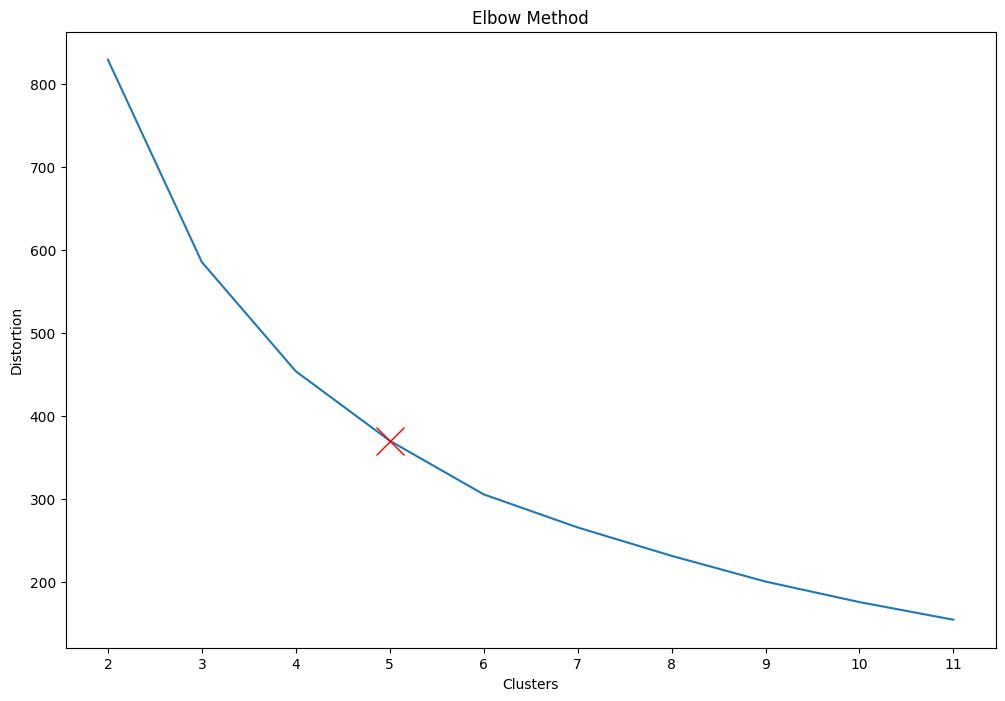

In [158]:
#Elbow
pcak = []
for k in range(2,12):
    kmean = KMeans(n_clusters=k)
    kmean.fit(pca_data)
    pcak.append(kmean.inertia_)
plt.figure(figsize=(12,8))
plt.plot(range(2,12),pcak)
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.xticks(range(2,12))
plt.plot(5, 370, marker="x", markersize=20, markeredgecolor="red")

In [26]:
corr_model = KMeans(n_clusters=5)
corr_model.fit(pca_data)
labels_corr = corr_model.labels_
np.unique(labels_corr)
#pipl = make_pipeline(pca_pct,pct_model)

array([0, 1, 2, 3, 4])

In [182]:
cent = corr_model.cluster_centers_
cent_x = cent[:,0]
cent_y = cent[:,1]

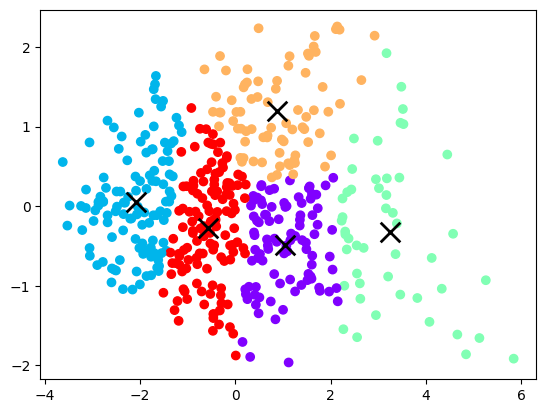

In [170]:
plt.scatter(pca_data[:,0],pca_data[:,1],c=labels_corr,cmap='rainbow')
plt.scatter(cent_x,cent_y,marker = "x", s=200,linewidths = 2, zorder = 10, c='black')

In [28]:
dftest = pd.DataFrame(pca_data)
dftest['Labels'] = labels_corr
dftest['Ticker'] = stocks_pct.columns.values

In [29]:
sym = stocks_pct.columns.values
sectors = []
for w in sym:
    sectors.append(yf.Ticker(str(w)).info['sector'])

A
AAL
AAP
AAPL
ABC
ABT
ACGL
ACN
ADI
ADM
ADP
ADSK
AEHR
AEL
AER
AFG
AGNC
AGO
AIN
AIZ
AJG
AKAM
AKZOY
ALB
ALK
ALSMY
ALV
AMAT
AMD
AMG
AMGN
AMP
AMT
AMX
AMZN
AN
ANDE
AON
APD
ARCC
ARW
ASB
ASML
ASX
ATVI
AVB
AVGO
AVT
AVY
AWK
AXP
AZN
AZO
BAESY
BAK
BAM
BAP
BASFY
BAX
BBBY
BBD
BBVA
BBY
BCS
BDORY
BDX
BEN
BIDU
BIIB
BK
BKU
BLK
BMO
BMRN
BMY
BNPQY
BNS
BPOP
BSAC
BSX
BTI
BUD
BWA
BXP
C
CAAS
CAG
CAH
CAR
CAT
CBD
CBSH
CCI
CCK
CFR
CHD
CHKP
CHRW
CHT
CHTR
CIB
CIM
CINF
CIOXY
CL
CLR
CM
CME
CMI
CMPGY
CNI
CNO
CNP
CNQ
COP
COST
CP
CPB
CRM
CRRFY
CS
CSCO
CSIQ
CUK
CVE
CYH
DAL
DANOY
DASTY
DE
DEO
DFS
DG
DGX
DHI
DIS
DISH
DLTR
DOX
DRI
DTE
DTEGY
DUFRY
DVA
EA
EBAY
EC
ECL
ED
EFX
EIX
EMN
EMR
ENB
ENGIY
ENLAY
ENS
EOG
EONGY
EPR
EQIX
EQR
ES
ESS
EW
EWBC
EXPE
EXR
F
FAST
FBHS
FCX
FE
FFIV
FHN
FIS
FISV
FITB
FIZZ
FL
FLT
FNF
FRC
GD
GE
GGAL
GIB
GILD
GIS
GM
GME
GNRC
GNW
GOOG
GPC
GPI
GPN
GRFS
GRMN
GSK
GWW
HAL
HAS
HBAN
HBI
HD
HDB
HII
HMC
HOG
HOLX
HON
HRL
HSBC
HSIC
HST
HUM
IBKR
IBN
ICE
ICL
IFF
IFNNY
IHG
ILMN
INFY
INT
INTU
IP
ISRG
ITUB
ITW
IVZ
JB

In [30]:
dftest['Sector'] = sectors
sectors_0 = dftest[dftest['Labels'] == 0]['Sector'].value_counts()
sectors_1 = dftest[dftest['Labels'] == 1]['Sector'].value_counts()
sectors_2 = dftest[dftest['Labels'] == 2]['Sector'].value_counts()
sectors_3 = dftest[dftest['Labels'] == 3]['Sector'].value_counts()
sectors_4 = dftest[dftest['Labels'] == 4]['Sector'].value_counts()
dftest['Sharpe'] = (stats_df['ret']-0.03)/stats_df['std'] # -0.03 To Account for Risk Free rate

In [174]:
portfolio = []
portfolio_size = 40
for x in range(int(portfolio_size/8)):
    sort_sharpe = dftest[dftest['Labels'] == x].sort_values(by=['Sharpe'])
    portfolio.extend(sort_sharpe.tail(8)['Ticker'].values)
portfolio

['CHTR',
 'TSCO',
 'TOELY',
 'CAR',
 'HUM',
 'NOW',
 'LNG',
 'AMZN',
 'URI',
 'ADP',
 'AVY',
 'FISV',
 'V',
 'MA',
 'MMC',
 'AJG',
 'DG',
 'AEHR',
 'LLY',
 'EA',
 'AMD',
 'MOH',
 'NFLX',
 'TSLA',
 'RSG',
 'WM',
 'MSFT',
 'NOC',
 'ORLY',
 'WCN',
 'TMO',
 'UNH',
 'GOOG',
 'HII',
 'LRCX',
 'ASML',
 'AON',
 'BSX',
 'MTD',
 'AVGO']

In [32]:
port_df = dftest[dftest['Ticker'].isin(portfolio)]

In [33]:

covmatrix = stocks_pct.cov()*252
covmatrix

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADI,ADM,...,WTFC,WU,WY,WYNN,XEL,XOM,XPO,YUM,ZBH,ZION
A,0.065587,0.040946,0.025585,0.035347,0.024460,0.035273,0.027087,0.035741,0.042107,0.025548,...,0.032900,0.026181,0.038217,0.043564,0.015715,0.024440,0.051766,0.026646,0.030984,0.034676
AAL,0.040946,0.254240,0.045081,0.040490,0.032740,0.028658,0.049421,0.040431,0.053195,0.043077,...,0.081172,0.044330,0.068126,0.106737,0.010277,0.047184,0.092597,0.044116,0.052143,0.076152
AAP,0.025585,0.045081,0.103413,0.024597,0.025426,0.023230,0.028812,0.027577,0.030404,0.027530,...,0.038461,0.026056,0.040105,0.040120,0.018681,0.024845,0.049568,0.028083,0.026510,0.037206
AAPL,0.035347,0.040490,0.024597,0.083784,0.022237,0.029686,0.024707,0.035174,0.046523,0.024078,...,0.030625,0.026617,0.037995,0.046147,0.016385,0.024012,0.046509,0.026763,0.028097,0.028368
ABC,0.024460,0.032740,0.025426,0.022237,0.067764,0.025664,0.027665,0.025832,0.026606,0.024472,...,0.031108,0.022455,0.032260,0.027236,0.015931,0.022787,0.033066,0.018958,0.024612,0.029575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XOM,0.024440,0.047184,0.024845,0.024012,0.022787,0.018338,0.031732,0.026768,0.032716,0.035497,...,0.049478,0.027378,0.041784,0.054980,0.014815,0.071627,0.042482,0.024494,0.030848,0.046492
XPO,0.051766,0.092597,0.049568,0.046509,0.033066,0.038212,0.042211,0.045725,0.063504,0.041182,...,0.072199,0.046164,0.060882,0.092073,0.014546,0.042482,0.222842,0.039047,0.043632,0.066775
YUM,0.026646,0.044116,0.028083,0.026763,0.018958,0.022958,0.026769,0.028832,0.030351,0.023269,...,0.033890,0.023001,0.036942,0.042377,0.016810,0.024494,0.039047,0.062108,0.029024,0.030367
ZBH,0.030984,0.052143,0.026510,0.028097,0.024612,0.028859,0.030299,0.031039,0.033964,0.026404,...,0.042575,0.025141,0.039485,0.053938,0.014415,0.030848,0.043632,0.029024,0.070979,0.038706


In [138]:
#Estimate Effienct Frontier
meanstd = []
size = 20
for x in range(1000):
    stocks = np.random.choice(portfolio,size,replace=False)
    weight = np.random.rand(size)
    weight = weight/sum(weight)
    testport_var = 0
    testport_mean = 0
    for i in range(size):
        testport_mean = testport_mean+weight[i]* stats_df[stats_df['Ticker'] == stocks[i]]['ret'].values[0]
        for j in range(size):
            testport_var = testport_var + weight[i] * weight[j] * covmatrix.loc[stocks[i],stocks[j]]
    meanstd.append([testport_mean,testport_var**0.5,{stocks[x]:weight[x] for x in range(len(stocks))}])
meanstd = np.array(meanstd)

Text(0, 0.5, 'Annualised Return')

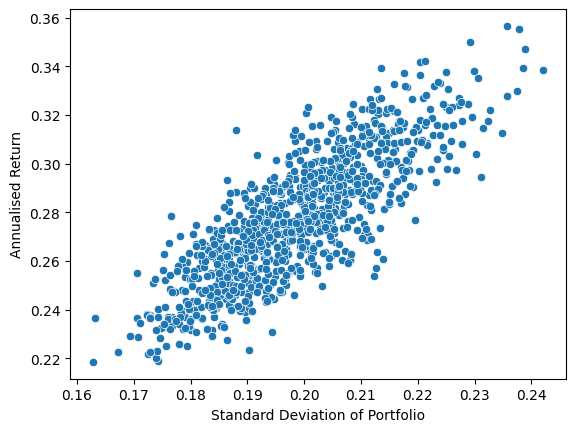

In [181]:
#res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}
sns.scatterplot(x=meanstd[:,1],y=meanstd[:,0])
plt.xlabel('Standard Deviation of Portfolio')
plt.ylabel('Annualised Return')

In [180]:
por = pd.DataFrame(meanstd)
por['sharpe'] = (por[0]/por[1]).astype(float)
best_port = por.iloc[por['sharpe'].idxmax()]
best_port[2]

{'V': 0.01815597944037116,
 'AEHR': 0.0757146196026148,
 'TSCO': 0.02995881899414847,
 'ORLY': 0.07972307628426992,
 'TSLA': 0.07829606855647668,
 'NOC': 0.04890556235469511,
 'WCN': 0.08534388398159656,
 'AJG': 0.058566763834376506,
 'MTD': 0.011586347507739691,
 'EA': 0.06834825274754477,
 'MOH': 0.028146025286717023,
 'MSFT': 0.04016328320819667,
 'NFLX': 0.06671058191006486,
 'TMO': 0.04421892822002955,
 'DG': 0.05197760308277433,
 'HUM': 0.0848546964626161,
 'TOELY': 0.03752506758324447,
 'HII': 0.01654938499389832,
 'LLY': 0.07316702307752486,
 'MMC': 0.002088032871100206}

In [141]:
stocks_pct[best_port[2].keys()]

,V,AEHR,TSCO,ORLY,TSLA,NOC,WCN,AJG,MTD,EA,MOH,MSFT,NFLX,TMO,DG,HUM,TOELY,HII,LLY,MMC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.007766,-0.030928,-0.023960,0.033782,0.003647,-0.004183,0.005533,0.000567,0.008504,-0.016908,0.000387,-0.000717,0.023121,0.022200,0.001694,0.002654,0.002740,0.026831,0.011485,0.006026
2,0.005525,0.000000,-0.008613,0.001421,-0.005088,-0.014774,-0.002751,0.010768,0.013042,-0.024570,-0.010457,0.011836,0.131198,-0.010697,0.006977,-0.014295,0.006375,-0.014124,-0.017032,0.010482
3,0.003254,0.000000,0.044635,0.015015,0.027392,0.009850,0.006438,-0.006448,0.014192,0.036944,-0.018787,0.011698,0.138833,0.000328,0.020785,-0.002686,0.034389,0.011939,-0.031468,0.008595
4,0.036898,-0.021277,0.008005,0.025626,0.039815,0.003348,0.005787,0.013262,0.027632,0.052632,0.009573,0.034338,-0.019561,0.022437,-0.002468,0.022486,0.036745,0.026192,0.009665,0.017338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,0.010364,0.101191,0.005602,0.007932,0.003829,0.066745,0.018341,0.006054,0.022913,0.019334,0.020258,0.004084,-0.017299,0.013862,0.005034,0.005794,-0.005466,0.046314,0.006822,0.010328
2512,-0.004060,0.038378,-0.032144,-0.005916,0.008402,0.008110,0.012646,0.010844,-0.027525,0.003810,-0.017770,-0.008470,0.130864,-0.035831,0.003283,-0.002930,0.014064,0.019156,-0.017133,-0.003302
2513,0.004345,-0.024987,-0.034586,-0.009218,-0.066474,0.002995,-0.018542,-0.023757,-0.019769,-0.002342,0.003256,-0.001395,-0.015493,-0.037084,-0.004824,0.010276,-0.018014,-0.000535,-0.000668,-0.015353
2514,0.016825,0.111586,0.041365,0.017991,0.034543,0.019944,0.007403,0.008917,0.026646,0.011655,0.016988,0.025281,0.079840,0.020293,0.009063,0.010270,0.071104,0.028312,0.035555,0.002394


In [142]:
weighted_outcome = stocks_pct[best_port[2].keys()].copy()
weights_lst = np.array(list(best_port[2].values()))
for x in range(len(weighted_outcome.columns)):
    weighted_outcome.iloc[:,x] = weighted_outcome.iloc[:,x]* weights_lst[x]
#weighted_outcome['Date'] = prices['Date'][1:]
weighted_outcome.insert(loc=0, column='Date', value=prices['Date'][1:])
weighted_outcome = weighted_outcome.dropna()

In [143]:
#randomly pick from clusters and compare
# train from year and test on month
def growth_calc(pers,inv):
    lst = []
    for x in pers:
        inv = inv+inv*x
        lst.append(inv)
    return lst

In [144]:
#Grab random portfolio top 20 sharpes equally weighted 5%
stats_df['sharpe'] = stats_df['ret']/stats_df['std']
top_shar = list(stats_df.sort_values('sharpe')[-20:]['Ticker'])
top_shar_pers = stocks_pct[top_shar].dropna()
top_shar_pers = (top_shar_pers/20).sum(axis=1)


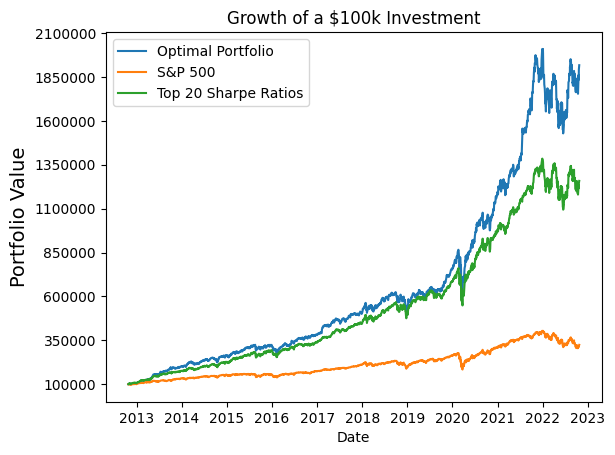

In [145]:
spy = yf.Ticker('spy')
spy_change = spy.history(start='2012-10-24',end='2022-10-25').pct_change()['Close'].values[1:]
#graph_df = pd.DataFrame(y_axis,columns=['Port'])
#graph_df['Spy'] = growth_calc(spy_change,100000)
y_axis = growth_calc(weighted_outcome.sum(axis=1,numeric_only=True).values,100000)
x_axis = weighted_outcome['Date']
sns.lineplot(x=x_axis,y=y_axis)
sns.lineplot(x=x_axis,y=growth_calc(spy_change,100000))
sns.lineplot(x=x_axis,y=growth_calc(top_shar_pers,100000))
plt.yticks(range(100000,2200000,250000))
plt.ticklabel_format(style='plain', axis='y')
plt.title('Growth of a $100k Investment')
plt.ylabel('Portfolio Value',size=14)
plt.legend(['Optimal Portfolio','S&P 500','Top 20 Sharpe Ratios'])

In [146]:
def foward_info(stks,wt,inv,start,end):
    foward_df = pd.DataFrame()
    for x in range(len(stks)):
        tick = yf.Ticker(stks[x])
        hist = tick.history(start=start,end=end,interval='1d')['Close']
        foward_df[stks[x]] = hist
    foward_df = foward_df.pct_change().dropna()
    for y in range(len(foward_df.columns)):
        foward_df.iloc[:,y] = foward_df.iloc[:,y]* wt[y]
    dates = tick.history(start=start,end=end,interval='1d').index
    return (growth_calc(foward_df.sum(axis=1,numeric_only=True).values,inv),dates)

In [147]:
for_spy = foward_info(['spy'],[1],100000,'2022-10-25','2022-12-4')
for_optimal = foward_info(list(best_port[2].keys()),np.array(list(best_port[2].values())),100000,'2022-10-25','2022-12-4')
for_random = foward_info(top_shar,[0.05 for x in range(20)],100000,'2022-10-25','2022-12-4')

([<matplotlib.axis.XTick at 0x259e866df40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

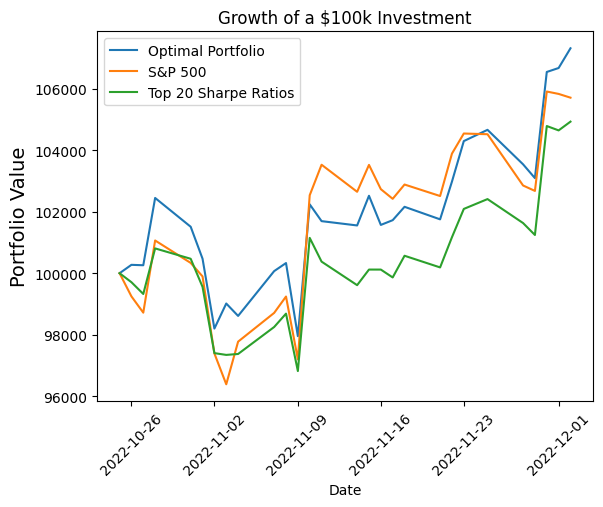

In [148]:
for_optimal[0].insert(0,100000)
for_spy[0].insert(0,100000)
for_random[0].insert(0,100000)
sns.lineplot(x=for_spy[1],y=for_optimal[0])
sns.lineplot(x=for_spy[1],y=for_spy[0])
sns.lineplot(x=for_spy[1],y=for_random[0])
plt.ticklabel_format(style='plain', axis='y')
plt.title('Growth of a $100k Investment')
plt.ylabel('Portfolio Value',size=14)
plt.legend(['Optimal Portfolio','S&P 500','Top 20 Sharpe Ratios'])
plt.xticks(for_spy[1][1::5],rotation=45)

